In [1]:
import os
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tcvae import tsms
from tcvae import dataset, model, localconfig
from IPython.display import Audio
import soundfile as sf

plt.style.use("dark_background")

2021-07-04 22:53:20.150 | INFO     | tcvae.train:<module>:18 - 1


## Setup Config, Load Test Set and Model

In [3]:
conf = localconfig.LocalConfig()
conf.load_config_from_file("checkpoints/Default_baseline16.json")
conf.dataset_dir = "complete_dataset"

_, _, test = dataset.get_dataset(conf)
test_iterable = iter(test)

vae = model.create_vae(conf)
vae.load_weights("checkpoints/baseline16.h5")

encoder = model.create_encoder(conf)
encoder_weights = vae.layers[1].get_weights()
encoder.set_weights(encoder_weights)

z, p, i, v = model.decoder_inputs(conf)

decoder_output = vae.layers[-1]([z, p, v, i])
decoder = tf.keras.Model([z, p, i, v], decoder_output)


In [4]:
z_mean, z_log_variance = None, None


def reconstruct_audio(freq, mag):
    phase = tsms.core.generate_phase(
        freq, conf.sample_rate,
        conf.frame_size
    )
    return tsms.core.harmonic_synthesis(
        h_freq=freq, h_mag=mag, h_phase=phase,
        sample_rate=conf.sample_rate,
        frame_step=conf.frame_size
    )


def get_prediction(batch, **kwargs):
    global z_mean, z_log_variance

    h = batch["h"]
    note_number = batch["note_number"]
    velocity= batch["velocity"]
    instrument_id = batch["instrument_id"]
    using_z = False

    if kwargs.get("instrument_id") is not None:
        desired_id = kwargs.get("instrument_id")
        instrument_id = np.zeros((1, 74))
        instrument_id[0, desired_id] = 1.

    if kwargs.get("note_number") is not None:
        desired_pitch = kwargs.get("note_number")
        note_number = np.zeros((1, 49))
        note_number[0, desired_pitch] = 1.

    if kwargs.get("velocity") is not None:
        desired_velocity = kwargs.get("velocity")
        velocity = np.zeros((1, 5))
        velocity[0, desired_velocity] = 1.

    if kwargs.get("z") is not None:
        desired_z = kwargs.get("z")
        using_z = True

    z, z_mean, z_log_variance = encoder.predict(h)

    if using_z:
        pred = decoder.predict([desired_z, note_number, instrument_id, velocity])
        print("Using custom z")
    else:
        pred = decoder.predict([z, note_number, instrument_id, velocity])
    pitch = 40 + tf.argmax(note_number[0])
    f0_from_note = tsms.core.midi_to_hz(
        tf.cast(pitch, dtype=tf.float32)
    )

    harmonics = tsms.core.get_number_harmonics(
        f0_from_note, conf.sample_rate
    )

    h_freq_pred = pred[:, :1001, :harmonics, 0]
    h_mag_pred = pred[:, :1001, :harmonics, 1]

    h_freq_gt = h[:, :1001, :harmonics, 0]
    h_mag_gt = h[:, :1001, :harmonics, 1]

    if not conf.db_norm:
        harmonic_indices = tf.range(1, harmonics + 1, dtype=tf.float32)

        h_freq_centered = h_freq_pred * f0_from_note
        h_freq_pred = h_freq_centered + f0_from_note * harmonic_indices

        h_freq_centered_gt = h_freq_gt * f0_from_note
        h_freq_gt = h_freq_centered_gt + f0_from_note * harmonic_indices

        h_mag_gt = np.clip(h_mag_gt, 0, 1)
        h_mag_pred = np.clip(h_mag_pred, 0, 1)

        low_amp = h_mag_pred < 0.02
        h_mag_pred[low_amp] = 0.
    else:
        db_limit = 120
        h_mag_pred = h_mag_pred * db_limit - db_limit
        h_mag_gt = h_mag_gt * db_limit - db_limit

        h_mag_pred = tsms.core.db_to_lin(h_mag_pred)
        h_mag_gt = tsms.core.db_to_lin(h_mag_gt)

        harmonic_indices = tf.range(1, harmonics + 1, dtype=tf.float32)
        harmonic_indices = harmonic_indices.numpy()

        f_var = f0_from_note * harmonic_indices * (2.0 ** (1.0 / 12.0) - 1.0)
        h_freq_centered = h_freq_pred * f_var
        h_freq_pred = h_freq_centered + f0_from_note * harmonic_indices

        h_freq_centered_gt = h_freq_gt * f_var
        h_freq_gt = h_freq_centered_gt + f0_from_note * harmonic_indices

    return (h_freq_pred, h_mag_pred), (h_freq_gt, h_mag_gt)

## Get Predictions

In [5]:
def save_predictions(batch, prefix, display=False,
                     instrument_id=None,
                     note_number=None,
                     velocity=None,
                     z=None):
    prefix = os.path.join("predictions", prefix)

    if not os.path.isdir(prefix):
        os.mkdir(prefix)

    (h_freq_pred, h_mag_pred), (h_freq_gt, h_mag_gt) = get_prediction(
        batch, instrument_id=instrument_id, velocity=velocity,
        note_number=note_number, z=z
    )

    audio_pred = reconstruct_audio(
        h_freq_pred, h_mag_pred
    )
    audio_gt = reconstruct_audio(
        h_freq_gt, h_mag_gt
    )

    plt.figure(figsize=(12, 12))
    plt.subplot(2, 1, 1)
    plt.plot(h_freq_gt[0])

    plt.subplot(2, 1, 2)
    plt.plot(h_freq_pred[0])

    if display:
        plt.show()
    else:
        plt.savefig(os.path.join(prefix, "freq.png"))
    plt.close()

    plt.figure(figsize=(12, 12))
    plt.subplot(2, 1, 1)
    plt.plot(h_mag_gt[0])

    plt.subplot(2, 1, 2)
    plt.plot(h_mag_pred[0])

    if display:
        plt.show()
    else:
        plt.savefig(os.path.join(prefix, "mag.png"))
    plt.close()

    if not display:
        gt_path = os.path.join(prefix, "gt_audio.wav")
        pred_path = os.path.join(prefix, "pred_audio.wav")

        sf.write(gt_path, audio_gt.numpy()[0], samplerate=conf.sample_rate,)
        sf.write(pred_path, audio_pred.numpy()[0], samplerate=conf.sample_rate)
        return
    return audio_gt, audio_pred


def get_sample():
    sample = model.sample_from_latent_space([z_mean, z_log_variance])
    print(np.mean(sample), np.min(sample), np.max(sample))
    return  sample

In [6]:
# for i in range(0, 20):
#     batch = next(test_iterable)
#     save_predictions(batch, str(i))

In [11]:
batch = next(test_iterable)

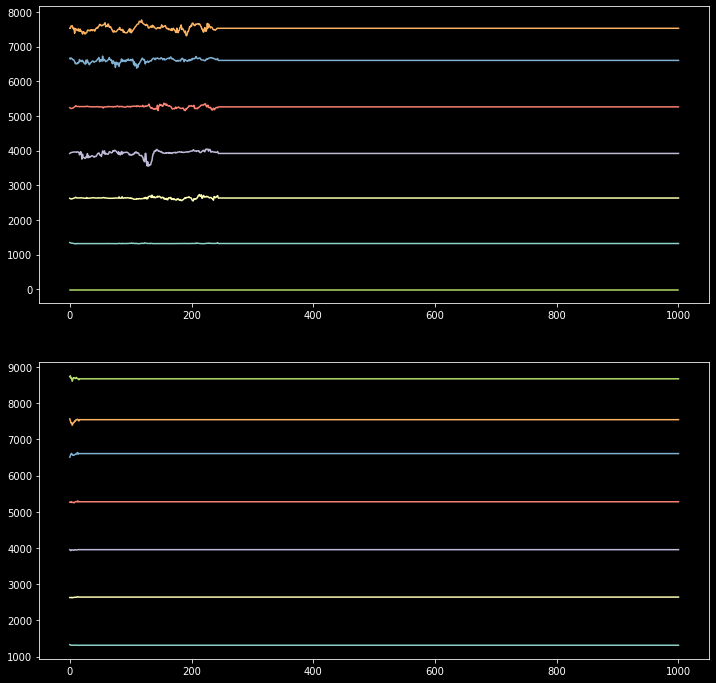

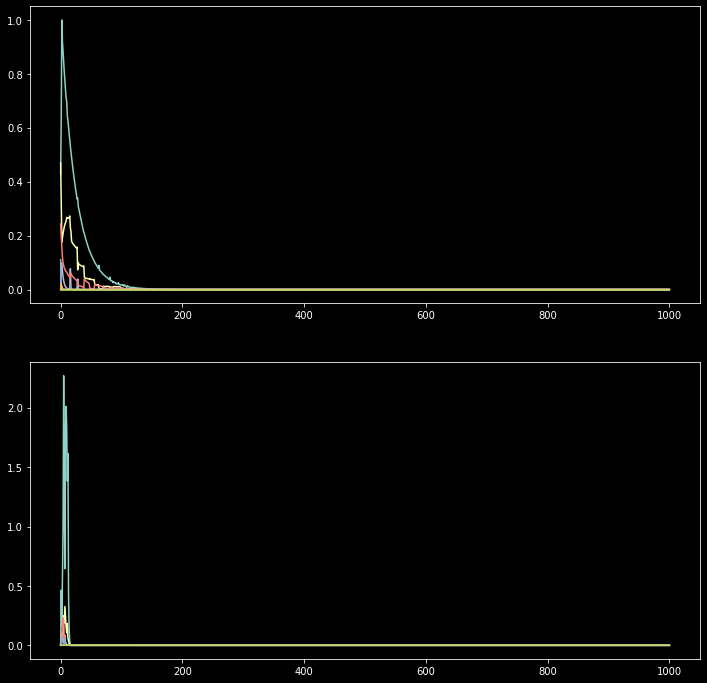

In [12]:
gt, pred = save_predictions(
    batch, "", display=True,
    # note_number=0
    # z=get_sample()
)

In [13]:
Audio(gt, rate=conf.sample_rate)

In [14]:
Audio(pred, rate=conf.sample_rate)